# Demo CatBoost Classification and Regression model

### Dependencies

In [1]:
from pathlib import Path
import sys

In [2]:
digital_twin_root = Path().resolve().parent
sys.path.append(str(digital_twin_root))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, f1_score, mean_absolute_error, mean_squared_error, 
    precision_score, recall_score, r2_score
)

from digital_twin.data_preparation.splitting_data import simple_split
from digital_twin.evaluation.data_metrics import DataMetrics
import digital_twin.load_data.load_from_file as load_data
from digital_twin.metrics.classification_metrics import ClassificationMetrics
from digital_twin.metrics.regression_metrics import RegressionMetrics
from digital_twin.models.catboost_model import CatBoostModel

### Load data

In [4]:
filename = "test_car_csv.csv"
path_to_data = Path().resolve().parent / "data"
path_to_file = path_to_data / "datasets" / filename

In [5]:
df = pd.read_csv(path_to_file)

In [6]:
df.head()

,year_of_manufacture,kilometers,engine_type,transmission_type,service_visits,car_brand,region,body_damage,engine_size,number_of_owners,car_color,tire_condition,market_value,failure_probability,failure_category
0,1994,49602,diesel,robotic,11,BMW,Central,medium,3.7,5,black,worn,1624500.00,0.10,Very Low
1,2018,493669,electric,robotic,1,Hyundai,Central,minor,5.1,3,white,worn,1545887.50,0.52,Medium
2,1991,340205,electric,automatic,5,BMW,South,severe,5.8,5,black,average,1571360.00,0.55,Medium
3,2007,371282,diesel,robotic,0,Mercedes,North,minor,1.5,1,red,average,1058181.25,0.35,Low
4,2017,141039,electric,automatic,13,BMW,Central,minor,4.5,1,black,worn,1673710.00,0.05,Very Low


### Data validation

In [7]:
data_metrics = DataMetrics()

In [8]:
data_metrics.validation(df, ["market_value", "failure_category", "failure_probability"])

True

### Build model

In [9]:
model_regr = CatBoostModel("regression")
model_clas = CatBoostModel("classifier")

In [10]:
data_for_regr = simple_split(df.drop(columns=["failure_probability", "failure_category"], axis=1), ["market_value"], 0.2)
data_for_clas = simple_split(df.drop(columns=["market_value", "failure_probability"], axis=1), ["failure_category"], 0.2)

In [11]:
cat_features = ["engine_type", "transmission_type", "car_brand", "region", "body_damage", "car_color", "tire_condition"]

In [12]:
model_regr.train(data_for_regr["x_train"], data_for_regr["y_train"], cat_features)

0:	learn: 357949.8696918	total: 117ms	remaining: 1m 56s
100:	learn: 17332.6087935	total: 7.26s	remaining: 1m 4s
200:	learn: 13492.9376083	total: 13.5s	remaining: 53.7s
300:	learn: 11172.9779945	total: 20.5s	remaining: 47.5s
400:	learn: 9646.1746703	total: 27.3s	remaining: 40.7s
500:	learn: 8550.2093826	total: 34.5s	remaining: 34.3s
600:	learn: 7817.1022510	total: 43.2s	remaining: 28.6s
700:	learn: 7219.6722019	total: 51.2s	remaining: 21.8s
800:	learn: 6628.3468411	total: 58.4s	remaining: 14.5s
900:	learn: 6278.3410243	total: 1m 6s	remaining: 7.32s
999:	learn: 5926.1780514	total: 1m 15s	remaining: 0us


In [13]:
model_clas.train(data_for_clas["x_train"], data_for_clas["y_train"], cat_features)

0:	learn: 1.3550934	total: 652ms	remaining: 10m 51s
100:	learn: 0.0921597	total: 43.5s	remaining: 6m 27s
200:	learn: 0.0636687	total: 1m 21s	remaining: 5m 23s
300:	learn: 0.0500750	total: 1m 59s	remaining: 4m 37s
400:	learn: 0.0404129	total: 2m 47s	remaining: 4m 9s
500:	learn: 0.0348683	total: 3m 35s	remaining: 3m 34s
600:	learn: 0.0291992	total: 4m 23s	remaining: 2m 54s
700:	learn: 0.0256822	total: 5m 4s	remaining: 2m 10s
800:	learn: 0.0228515	total: 5m 48s	remaining: 1m 26s
900:	learn: 0.0205087	total: 6m 27s	remaining: 42.6s
999:	learn: 0.0184548	total: 7m 7s	remaining: 0us


### Results

In [14]:
def evaluate_classification(y_true: pd.Series, y_pred: pd.Series) -> dict:
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1': f1_score(y_true, y_pred, average='weighted')
    }

def evaluate_regression(y_true: pd.Series, y_pred: pd.Series) -> dict:
    mse = mean_squared_error(y_true, y_pred)
    return {
        'mae': mean_absolute_error(y_true, y_pred),
        'mse': mse,
        'rmse': np.sqrt(mse),
        'r2': r2_score(y_true, y_pred)
    }

def print_metrics(metrics: dict):
    for name, value in metrics.items():
        print(f"{name:>10}: {value:.4f}")

In [15]:
def plot_metrics(metrics: dict, title: str = 'Model Metrics'):
    plt.figure(figsize=(10, 5))
    
    if not metrics:
        print("No data for visualisation!")
        return
    
    names = list(metrics.keys())
    values = list(metrics.values())
    
    clean_values = [0 if v is None or np.isnan(v) else v for v in values]
    
    bars = plt.bar(names, clean_values, color='skyblue')
    
    for bar, val in zip(bars, clean_values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}',
                ha='center', va='bottom')
    
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    max_val = max(clean_values) if clean_values else 1
    plt.ylim(0, max_val * 1.15)
    
    plt.tight_layout()
    plt.show()

In [16]:
y_pred_regr = model_regr.predict(data_for_regr["x_test"])

In [17]:
y_pred_clas = model_clas.predict(data_for_clas["x_test"])


---Regression Metrics---

       mae: 2215.6333
       mse: 7945106.5335
      rmse: 2818.7065
        r2: 0.9999


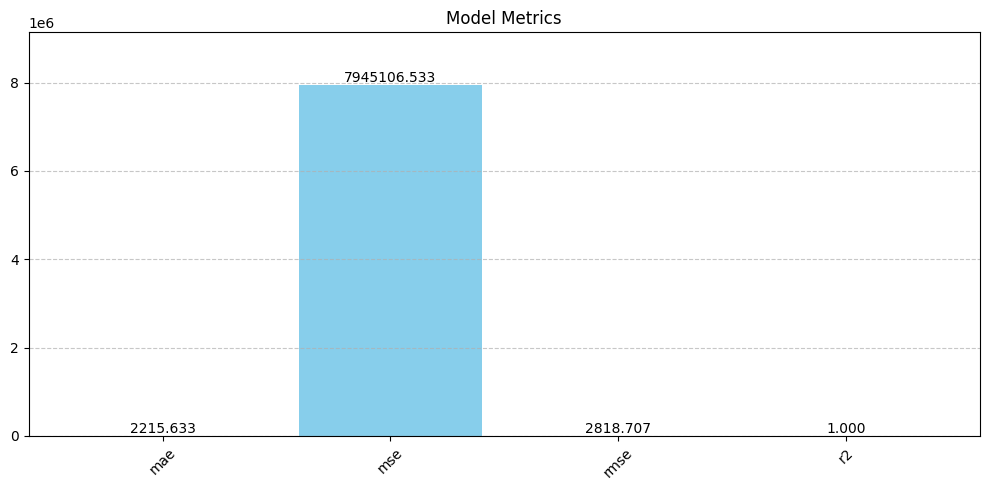

In [18]:
print("\n---Regression Metrics---\n")
metrics = evaluate_regression(data_for_regr["y_test"], y_pred_regr)
print_metrics(metrics)
plot_metrics(metrics)


---Classification Metrics---

  accuracy: 0.9980
 precision: 0.9980
    recall: 0.9980
        f1: 0.9980


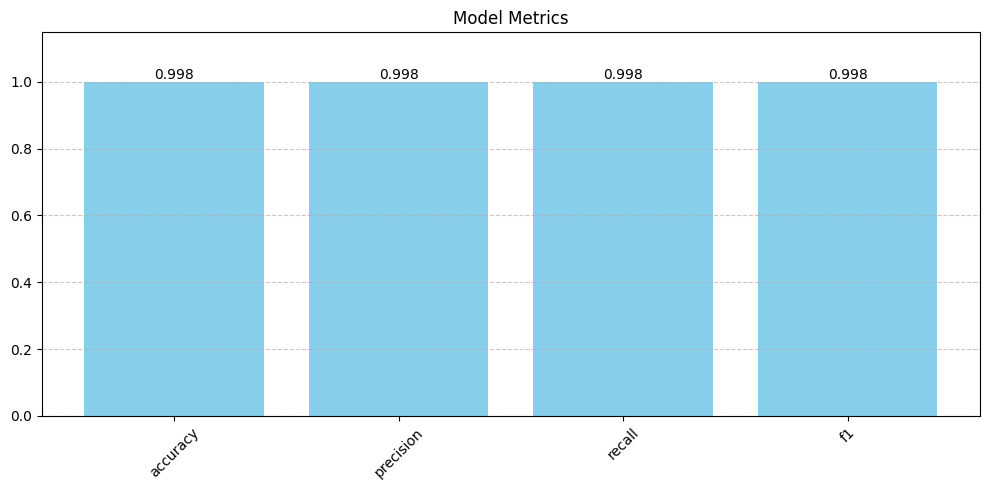

In [19]:
print("\n---Classification Metrics---\n")
metrics = evaluate_classification(data_for_clas["y_test"], y_pred_clas)
print_metrics(metrics)
plot_metrics(metrics)

### Metrics from the project

In [23]:
metrics = RegressionMetrics.evaluate_all(data_for_regr["y_test"], y_pred_regr)
print(metrics)

{'mae': 2215.633340337485, 'mse': 7945106.5334515935, 'rmse': np.float64(2818.706535532139), 'r2': 0.9999462545396587, 'mape': np.float64(27.34372916784718)}


In [24]:
metrics = ClassificationMetrics.evaluate_all(data_for_clas["y_test"], y_pred_clas)
print(metrics)

{'accuracy': 0.99795, 'precision': 0.9979505309472475, 'recall': 0.99795, 'f1': 0.9979501435443173}
